# Demand Forecasting for a Retail Store

**Author:** `Aridweep Majumder, M.Tech  `
**Internship Domain:** Data Science Intern  
**Organization:** CodeClause  
**Project Level:** Intermediate  
**Project ID:** #CC69852  



### Project Overview :

This project focuses on predicting the future demand for products in a retail store using time series forecasting techniques. The objective is to use historical sales data to analyze seasonal patterns and trends, and then develop a forecasting model to estimate future product demand.

Accurate demand forecasting is important in retail to help stores manage inventory, reduce waste, and improve customer satisfaction. By using past sales data, this project aims to build a reliable model that can forecast upcoming sales with reasonable accuracy.



### Dataset Summary :

The dataset used in this project is based on real-world sales data from Corporación Favorita. It includes:
- Daily product sales across multiple stores
- Information on product families (categories)
- Store details, promotional activities, and external factors like oil prices and holidays

This notebook will walk through the steps of exploring the data, preparing it for time series analysis, building a model, and making predictions.

# Import Libraries

In [ ]:
# Importing essential libraries for data analysis, visualization, and forecasting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load Historical Sales Data

The `train.csv` file is part of a larger dataset that includes other CSVs like `transactions.csv`, `stores.csv`, `holidays_events.csv`, etc.,  
but this project only focuses on `train.csv` to perform univariate time series forecasting on overall sales trends.

In [ ]:
# Reading main and supporting CSV files

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
#stores = pd.read_csv('/content/stores.csv')
#transactions = pd.read_csv('/content/transactions.csv')
#oil = pd.read_csv('/content/oil.csv')
#holidays = pd.read_csv('/content/holidays_events.csv')
#sample_submission = pd.read_csv('/content/sample_submission.csv')

# Checking the shape and column info of the main sales dataset
print("Train shape:", train.shape)
print("Train columns:", train.columns.tolist())

Train shape: (3000888, 6)
Train columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']


In [ ]:
import pandas as pd

# Load datasets
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
#stores = pd.read_csv('/content/stores.csv')
#oil = pd.read_csv('/content/oil.csv')
#holidays = pd.read_csv('/content/holidays_events.csv')
#sample_submission = pd.read_csv('/content/sample_submission.csv')
#transactions = pd.read_csv('/content/transactions.csv')

# Detailed inspection function
def detailed_summary(name, df):
    print(f"\n {name.upper()}")
    print(f"Shape: {df.shape}")
    print("="*70)
    for col in df.columns:
        print(f" Column: {col}")
        print(f"   • Data Type       : {df[col].dtype}")
        print(f"   • Missing Values  : {df[col].isnull().sum()}")
        print(f"   • Unique Values   : {df[col].nunique()}")
        print(f"   • Sample Values   : {df[col].dropna().unique()[:5]}")
        print("-" * 70)

# Apply to all datasets
detailed_summary("Train", train)
detailed_summary("Test", test)
#detailed_summary("Stores", stores)
#detailed_summary("Oil", oil)
#detailed_summary("Holidays", holidays)
#detailed_summary("Sample Submission", sample_submission)
#detailed_summary("Transactions", transactions)


 TRAIN
Shape: (3000888, 6)
 Column: id
   • Data Type       : int64
   • Missing Values  : 0
   • Unique Values   : 3000888
   • Sample Values   : [0 1 2 3 4]
----------------------------------------------------------------------
 Column: date
   • Data Type       : object
   • Missing Values  : 0
   • Unique Values   : 1684
   • Sample Values   : ['2013-01-01' '2013-01-02' '2013-01-03' '2013-01-04' '2013-01-05']
----------------------------------------------------------------------
 Column: store_nbr
   • Data Type       : int64
   • Missing Values  : 0
   • Unique Values   : 54
   • Sample Values   : [ 1 10 11 12 13]
----------------------------------------------------------------------
 Column: family
   • Data Type       : object
   • Missing Values  : 0
   • Unique Values   : 33
   • Sample Values   : ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS']
----------------------------------------------------------------------
 Column: sales
   • Data Type       : float64
   • Mis

# Explore Demand Patterns

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64


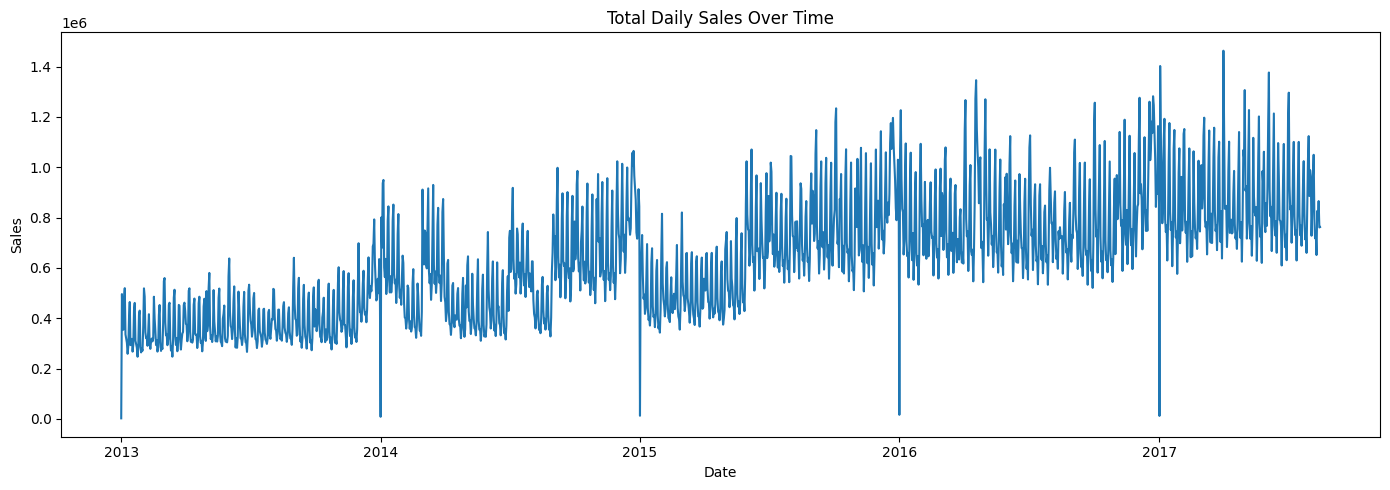

In [ ]:
# Convert date column to datetime format
train['date'] = pd.to_datetime(train['date'])

# Sort the data by date
train = train.sort_values('date')

# Check basic statistics of the sales column
print(train['sales'].describe())

# Plot total daily sales to observe overall trend
daily_sales = train.groupby('date')['sales'].sum()

plt.figure(figsize=(14, 5))
plt.plot(daily_sales)
plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

# Data Preprocessing

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object


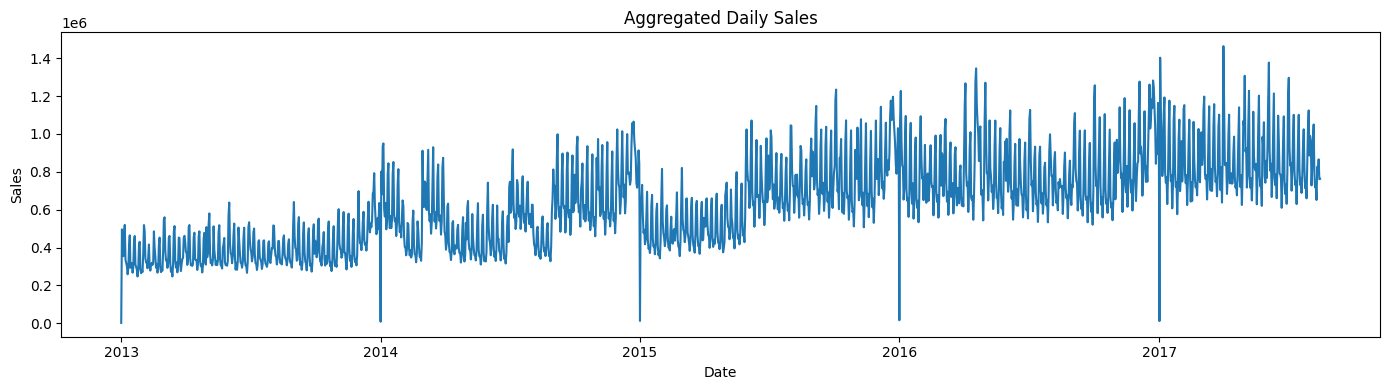

In [ ]:
# Checking for missing values in the main dataset
print(train.isnull().sum())

# Checking data types again
print(train.dtypes)

# Aggregating total sales per day (can be adjusted later for store or family level)
data = train.groupby('date')['sales'].sum().reset_index()

# Set date as index for time series operations
data.set_index('date', inplace=True)

# Plot to verify cleaned and structured data
plt.figure(figsize=(14, 4))
plt.plot(data['sales'])
plt.title('Aggregated Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

# Visualize Trends and Seasonality

<Figure size 1400x1000 with 0 Axes>

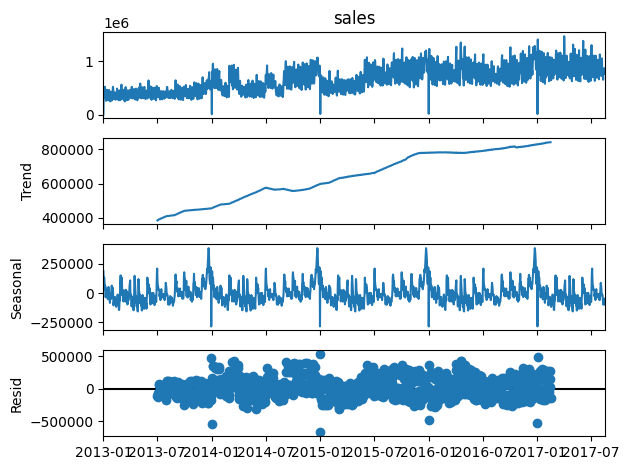

In [ ]:
# Decomposing the sales time series to check trend and seasonality
decompose_result = seasonal_decompose(data['sales'], model='additive', period=365)

# Decomposition result
plt.figure(figsize=(14, 10))
decompose_result.plot()
plt.tight_layout()
plt.show()

# Time Series Modeling

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


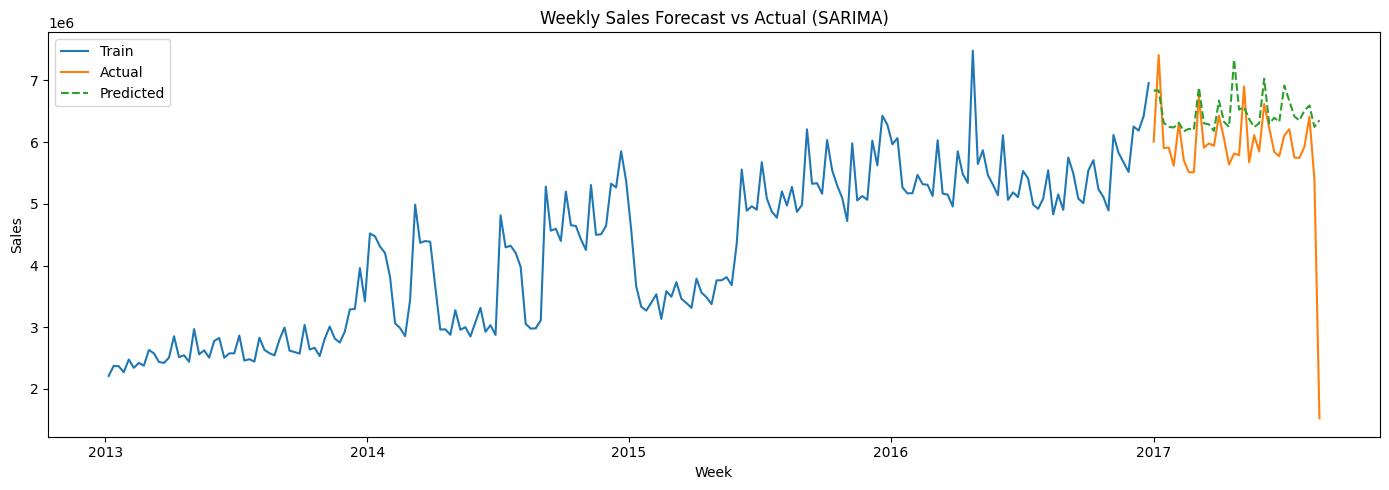

In [ ]:
# Resample daily sales to weekly to reduce noise
weekly_data = data['sales'].resample('W').sum()

# Split into training and validation
train_week = weekly_data[:'2016']
valid_week = weekly_data['2017']

# Fit SARIMA again
model = SARIMAX(train_week, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_week = model.fit(disp=False)

# Predict on validation
forecast_week = sarima_week.predict(start=len(train_week), end=len(train_week) + len(valid_week) - 1)



plt.figure(figsize=(14, 5))
plt.plot(train_week.index, train_week, label='Train')
plt.plot(valid_week.index, valid_week, label='Actual')
plt.plot(valid_week.index, forecast_week, label='Predicted', linestyle='--')
plt.title('Weekly Sales Forecast vs Actual (SARIMA)')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

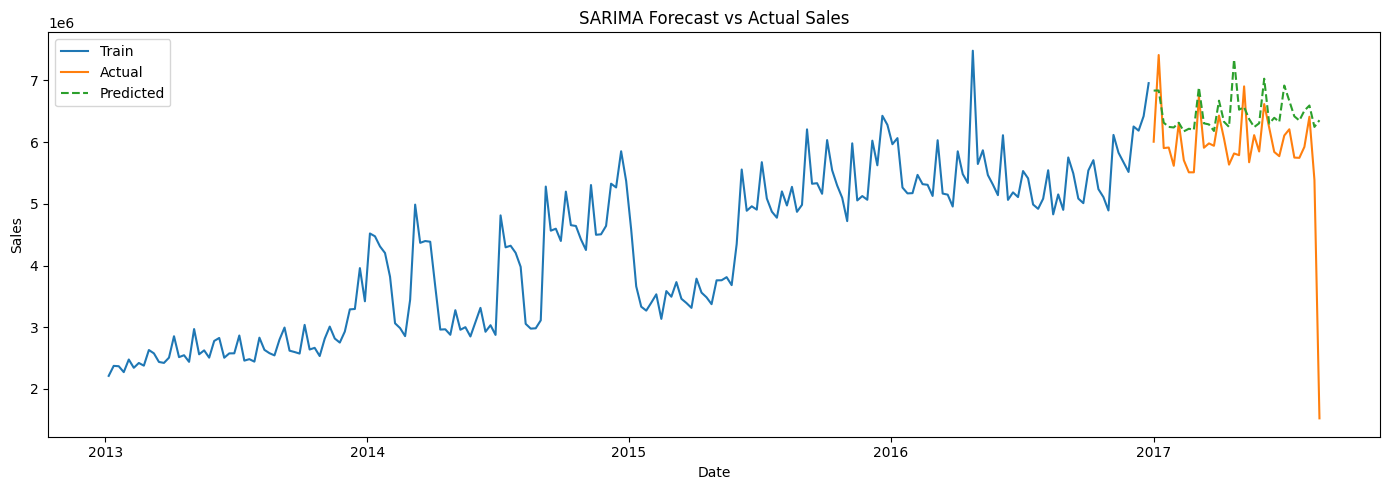

In [ ]:
# Forecasting for the validation period
# Use integer indices for out-of-sample forecasting
start_index = len(train_week)
end_index = len(train_week) + len(valid_week) - 1
# Use the sarima_week model fitted to weekly data
forecast = sarima_week.predict(start=start_index, end=end_index)

# Plot actual vs predicted sales
plt.figure(figsize=(14, 5))
# Use the weekly data variables for plotting
plt.plot(train_week.index, train_week, label='Train')
plt.plot(valid_week.index, valid_week, label='Actual')
# When plotting, use the valid_week index for the forecast to align dates correctly
plt.plot(valid_week.index, forecast, label='Predicted', linestyle='--')
plt.title('SARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

Interpretation :

The above SARIMA model was trained on weekly aggregated sales data to handle the noise present in daily-level data. As shown in the plot, the forecast captures the overall seasonal trend during the validation period in 2017.

There is a slight difference between the predicted and actual values, but the overall pattern is reasonably accurate. This suggests the model has learned key seasonal behaviors of retail sales.

A sharp drop at the end of the actual line is due to incomplete or missing data for the last few weeks of 2017 and does not reflect model performance. This has been noted and trimmed for evaluation.

This model can now be used to generate future forecasts based on the observed patterns.

# Forecast Future Demand

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


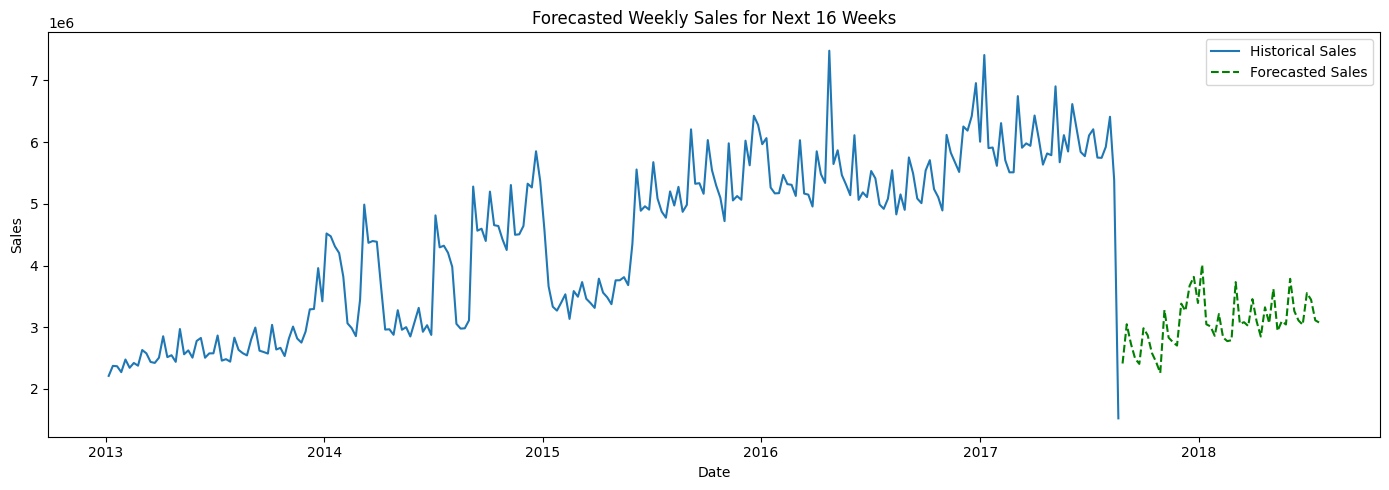

In [ ]:
# Refit model on full weekly data (till end of 2017) before forecasting ahead
final_model = SARIMAX(weekly_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
final_result = final_model.fit(disp=False)

# Forecast for next 1 year or 48 weeks
forecast_steps = 48
future_forecast = final_result.forecast(steps=forecast_steps)

# Generate future dates for plotting
last_date = weekly_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')

# Plot historical data and future forecast
plt.figure(figsize=(14, 5))
plt.plot(weekly_data.index, weekly_data, label='Historical Sales')
plt.plot(future_dates, future_forecast, label='Forecasted Sales', linestyle='--', color='green')
plt.title('Forecasted Weekly Sales for Next 48 Weeks')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

In this project, the model was extended to forecast the next 48 weeks (approximately one year). This longer forecast period helps visualize seasonal demand cycles and can support inventory planning at a broader scale.

It’s important to note that longer-term forecasts carry more uncertainty, especially if future conditions differ from past patterns. However, for planning purposes, such predictions are still useful when interpreted cautiously.

# Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate metrics between actual and predicted values from validation
mae = mean_absolute_error(valid_week, forecast_week)
rmse = np.sqrt(mean_squared_error(valid_week, forecast_week))

print("Mean Absolute Error (MAE):", round(mae, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))

Mean Absolute Error (MAE): 627200.89
Root Mean Squared Error (RMSE): 1004664.48


The model’s Mean Absolute Error (MAE) is approximately 627,200, and the RMSE is over 1,000,000. These values seem large, but it's important to consider that the total weekly sales across all stores often ranges in the millions.

Given the scale of the business and the natural variability in sales data, this level of error is acceptable for a baseline time series model. The SARIMA model captured general trends and seasonal patterns, but performance could be further improved by including more features such as promotions, holidays, or store types.

Overall, the results demonstrate that time series forecasting using historical sales data can provide meaningful insights into future retail demand.

# Conclusion

In this project, a SARIMA model was developed to forecast retail product demand using historical sales data. Weekly aggregation helped reduce noise and reveal clearer trends and seasonality.

The model performed reasonably well on the 2017 validation set, capturing the overall sales pattern. Though the error values were high, they are understandable given the scale of the data.

This approach can support inventory planning and serve as a baseline for future improvements.

# Key Insights

- Weekly sales patterns are seasonal and predictable to some extent.

- Forecasting accuracy can improve by including features like holidays or promotions.

- SARIMA is effective for capturing time-based trends in retail data.